# Project 2 - LendingClub
## OPAN 6604 - Predictive Analytics
Mike Johnson - SAXA

****

## Set Up

In [1]:
# Import libraries

# Data Processing
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn import svm

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Load dataset
df = pd.read_csv('../data/raw/LC_HW2.csv')

df.head()

,all_util,annual_inc,application_type,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_2yrs,dti,emp_length,fico_range_high,fico_range_low,...,mo_sin_old_rev_tl_op,mort_acc,mths_since_last_record,mths_since_recent_inq,open_acc,pub_rec_bankruptcies,term,total_bal_ex_mort,verification_status,int_rate
0,80.0,36000.0,Individual,0,0,0,26.33,NaN,674,670,...,35,0,NaN,0.0,5,0,36 months,34683,Verified,18.62
1,61.0,45000.0,Individual,0,0,0,38.51,1 year,734,730,...,103,0,NaN,0.0,14,0,60 months,63873,Not Verified,16.08
2,31.0,53040.0,Individual,0,0,0,25.20,< 1 year,809,805,...,145,4,NaN,0.0,9,0,36 months,24452,Verified,7.56
3,87.0,125000.0,Individual,0,0,0,27.87,10+ years,684,680,...,230,4,NaN,19.0,14,0,36 months,141033,Verified,17.30
4,75.0,73000.0,Individual,0,0,0,35.12,10+ years,759,755,...,126,1,NaN,13.0,19,0,36 months,160302,Not Verified,10.81


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   all_util                    99984 non-null   float64
 1   annual_inc                  100000 non-null  float64
 2   application_type            100000 non-null  object 
 3   chargeoff_within_12_mths    100000 non-null  int64  
 4   collections_12_mths_ex_med  100000 non-null  int64  
 5   delinq_2yrs                 100000 non-null  int64  
 6   dti                         99814 non-null   float64
 7   emp_length                  91331 non-null   object 
 8   fico_range_high             100000 non-null  int64  
 9   fico_range_low              100000 non-null  int64  
 10  home_ownership              100000 non-null  object 
 11  inq_last_12m                100000 non-null  int64  
 12  loan_amnt                   100000 non-null  int64  
 13  mo_sin_old_il_a

****

## Train / Test Split

In [4]:
# Create Train / Test Split
X = df.drop(columns = ['int_rate']) # Features
y = df['int_rate'] # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.25, # Reserve 25% of data for testing
                                                    random_state = 206) # Set random state for reproducibility 

## Preprocessing

In [113]:
# Remove total_acc. Feature not present at loan origination
X_train = X_train.drop(columns = ['open_acc'])
X_test = X_test.drop(columns = ['open_acc'])

### NA Handling

In [5]:
# Check for NA's
X_train.isna().sum()

all_util                         15
annual_inc                        0
application_type                  0
chargeoff_within_12_mths          0
collections_12_mths_ex_med        0
delinq_2yrs                       0
dti                             138
emp_length                     6502
fico_range_high                   0
fico_range_low                    0
home_ownership                    0
inq_last_12m                      0
loan_amnt                         0
mo_sin_old_il_acct             1661
mo_sin_old_rev_tl_op              0
mort_acc                          0
mths_since_last_record        68186
mths_since_recent_inq          7543
open_acc                          0
pub_rec_bankruptcies              0
term                              0
total_bal_ex_mort                 0
verification_status               0
dtype: int64

#### all_util

Represents the balance to credit limit on all trades. This can be measured by the following equation:


$$all\_util = 100 \times \frac{\text{total balance on all accounts}}{\text{total credit-limit on accounts}}$$


An NA would likely mean that applicant does not have any trades with a positive credit-limit, leading to a denomincator of 0. This means that applicant likely has no open credit-limit lines, so their utilization ratio is 0%.

For this column, 0 will be imputed for any NA's.

In [6]:
# Imput 0 for NA's in all_util
X_train['all_util'] = X_train['all_util'].fillna(0) # Apply to training set
X_test['all_util'] = X_test['all_util'].fillna(0) # Apply to test set

# Confirm NA's handled
print(f"NA count in training set: {X_train['all_util'].isna().sum()}")
print(f"NA count in test set: {X_test['all_util'].isna().sum()}")

NA count in training set: 0
NA count in test set: 0


### dti

A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income. 

$$dti = 100 \times \frac{\text{total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan}}{\text{borrower’s self-reported monthly income}}$$

An NA likely means that the applicant had no income and is reflected in the training set. Imputing 0 is implies an exceptional DTI, but no income suggests a credit risk. On the other hand, imputing 999 to represent these missing values might mislead the training of the model. 

Instead, median dti will be imputed and a dummy variable that flags missing values in the dti so that the model can learn whether DTI carries information.

In [7]:
# Confirm NA's in dti also have an annual income of 0. The training set largely has annual incomes of 0 with a max value of 2.
X_train.loc[X_train['dti'].isna(), 'annual_inc'].describe()

count    138.000000
mean       0.014493
std        0.170251
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.000000
Name: annual_inc, dtype: float64

In [8]:
# Run stats of DTI. Data is skewed right. Impute the median for NAs
X_train['dti'].describe()

count    74862.000000
mean        21.599858
std         19.494020
min          0.000000
25%         13.380000
50%         19.750000
75%         26.990000
max        999.000000
Name: dti, dtype: float64

In [9]:
# Add conditional column that identifies applicants with NA DTI
X_train['dti_missing'] = X_train['dti'].isna().astype(int)
X_test['dti_missing'] = X_test['dti'].isna().astype(int)


In [10]:
# Impute median for NA's in DTI.
dti_median = X_train['dti'].median()
X_train['dti'] = X_train['dti'].fillna(dti_median) # Apply to training set
X_test['dti'] = X_test['dti'].fillna(dti_median) # Apply to test set

# Confirm NA's handled
print(f"NA count in training set: {X_train['dti'].isna().sum()}")
print(f"NA count in test set: {X_test['dti'].isna().sum()}")

NA count in training set: 0
NA count in test set: 0


### emp_length

Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 

NA's likely represent cases where the applicant did not provide their data related to the feature. To handle NA's, the feature will be converted to an integer, impute the median, and add a dummy variable that identifies a missing emp_length.

In [11]:
# Convert emp_length to numeric

# Define order of ordinal values
emp_length_order = ['< 1 year','1 year','2 years','3 years','4 years','5 years','6 years','7 years','8 years','9 years','10+ years']

# Convert to an *ordered* categorical, then grab the integer codes
X_train['emp_length_num'] = pd.Categorical(X_train['emp_length'],
                                           categories = emp_length_order,
                                           ordered = True).codes

X_test['emp_length_num'] = pd.Categorical(X_test['emp_length'],
                                          categories = emp_length_order,
                                          ordered = True).codes

# -1 = NaN/missing -> replace with actual NaN
X_train.loc[X_train['emp_length_num'] == -1, 'emp_length_num'] = np.nan

X_test.loc[X_test['emp_length_num'] == -1, 'emp_length_num'] = np.nan

In [12]:
# Drop emp_length
X_train = X_train.drop(columns='emp_length')
X_test = X_test.drop(columns='emp_length')

In [13]:
# Run stats of emp_lenth_num. Impute the median for NAs
X_train['emp_length_num'].describe()

count    68498.000000
mean         5.309308
std          3.841817
min          0.000000
25%          2.000000
50%          5.000000
75%         10.000000
max         10.000000
Name: emp_length_num, dtype: float64

In [14]:
# Add conditional column that identifies applicants with NA emp_length_num
X_train['emp_length_missing'] = X_train['emp_length_num'].isna().astype(int)
X_test['emp_length_missing'] = X_test['emp_length_num'].isna().astype(int)

In [15]:
# Impute median for NA's in emp_length_num.
emp_length_median = X_train['emp_length_num'].median()
X_train['emp_length_num'] = X_train['emp_length_num'].fillna(emp_length_median) # Apply to training set
X_test['emp_length_num'] = X_test['emp_length_num'].fillna(emp_length_median) # Apply to test set

# Confirm NA's handled
print(f"NA count in training set: {X_train['emp_length_num'].isna().sum()}")
print(f"NA count in test set: {X_test['emp_length_num'].isna().sum()}")

NA count in training set: 0
NA count in test set: 0


### mo_sin_old_il_acct

Months since oldest bank installment account opened. NA's likely represent cases where the applicant has no installment account.

In these cases, 0 will be imputed and a dummy variable will be added to flag instances where there are no installment accounts.

In [16]:
# Add conditional column that identifies applicants with NA mo_sin_old_il_acct.
X_train['mo_sin_old_il_acct_missing'] = X_train['mo_sin_old_il_acct'].isna().astype(int)
X_test['mo_sin_old_il_acct_missing'] = X_test['mo_sin_old_il_acct'].isna().astype(int)

In [17]:
# Imput 0 for NA's in all_util
X_train['mo_sin_old_il_acct'] = X_train['mo_sin_old_il_acct'].fillna(0) # Apply to training set
X_test['mo_sin_old_il_acct'] = X_test['mo_sin_old_il_acct'].fillna(0) # Apply to test set

# Confirm NA's handled
print(f"NA count in training set: {X_train['mo_sin_old_il_acct'].isna().sum()}")
print(f"NA count in test set: {X_test['mo_sin_old_il_acct'].isna().sum()}")

NA count in training set: 0
NA count in test set: 0


### mths_since_last_record

The number of months since the last public record. There are a lot of NA's (90% in the training set).

This column will be dropped since there's isn't enough data to work with.

In [18]:
# Percent of values missing
X_train['mths_since_last_record'].isna().sum() / len(X_train)

0.9091466666666667

In [19]:
# Drop emp_length
X_train = X_train.drop(columns = 'mths_since_last_record')
X_test = X_test.drop(columns = 'mths_since_last_record')

### mths_since_recent_inq

Months since most recent inquiry. NA's likely mean that there are no inquiries on file for the applicant.

NA's will be imputed with 0 and add a dummy variable that flags the NA's.

In [20]:
# Add conditional column that identifies applicants with NA DTI
X_train['mths_since_recent_inq_missing'] = X_train['mths_since_recent_inq'].isna().astype(int)
X_test['mths_since_recent_inq_missing'] = X_test['mths_since_recent_inq'].isna().astype(int)

In [21]:
# Imput 0 for NA's in all_util
X_train['mths_since_recent_inq'] = X_train['mths_since_recent_inq'].fillna(0) # Apply to training set
X_test['mths_since_recent_inq'] = X_test['mths_since_recent_inq'].fillna(0) # Apply to test set

# Confirm NA's handled
print(f"NA count in training set: {X_train['mths_since_recent_inq'].isna().sum()}")
print(f"NA count in test set: {X_test['mths_since_recent_inq'].isna().sum()}")

NA count in training set: 0
NA count in test set: 0


## Outlier Detection and Handling

In [22]:
X_train.describe()

,all_util,annual_inc,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_2yrs,dti,fico_range_high,fico_range_low,inq_last_12m,loan_amnt,...,mort_acc,mths_since_recent_inq,open_acc,pub_rec_bankruptcies,total_bal_ex_mort,dti_missing,emp_length_num,emp_length_missing,mo_sin_old_il_acct_missing,mths_since_recent_inq_missing
count,75000.000000,7.500000e+04,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.00000,75000.000000,75000.000000,...,75000.000000,75000.000000,75000.000000,75000.000000,7.500000e+04,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000
mean,55.039867,8.845330e+04,0.005880,0.015093,0.217240,21.596454,710.602960,706.60280,2.058760,16821.198667,...,1.359507,6.292573,12.141587,0.092307,6.060381e+04,0.001840,5.282493,0.086693,0.022147,0.100573
std,20.179016,9.330522e+04,0.087057,0.136183,0.712479,19.476238,35.622134,35.62151,2.310346,10436.449955,...,1.762138,5.918878,6.102140,0.296109,5.800226e+04,0.042856,3.672542,0.281387,0.147161,0.300765
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,664.000000,660.00000,0.000000,1000.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,41.000000,5.000000e+04,0.000000,0.000000,0.000000,13.390000,684.000000,680.00000,0.000000,8500.000000,...,0.000000,1.000000,8.000000,0.000000,2.482175e+04,0.000000,2.000000,0.000000,0.000000,0.000000
50%,55.000000,7.300000e+04,0.000000,0.000000,0.000000,19.750000,704.000000,700.00000,1.000000,15000.000000,...,1.000000,5.000000,11.000000,0.000000,4.480500e+04,0.000000,5.000000,0.000000,0.000000,0.000000
75%,69.000000,1.050000e+05,0.000000,0.000000,0.000000,26.970000,729.000000,725.00000,3.000000,24000.000000,...,2.000000,10.000000,15.000000,0.000000,7.685200e+04,0.000000,10.000000,0.000000,0.000000,0.000000
max,185.000000,8.645185e+06,6.000000,10.000000,19.000000,999.000000,850.000000,845.00000,40.000000,40000.000000,...,32.000000,25.000000,67.000000,7.000000,1.196294e+06,1.000000,10.000000,1.000000,1.000000,1.000000


### all_util

Instances greater than 100% are rare and create noise. Instances > 100% will be removed.

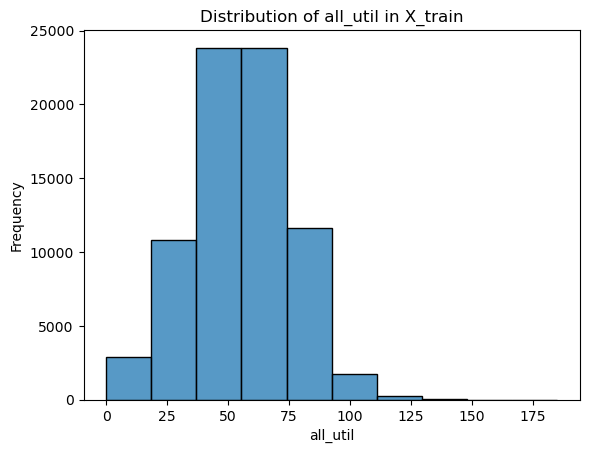

In [23]:
# Visualize distribution of all_util
sns.histplot(X_train['all_util'], bins = 10)

# Add labels and title
plt.title('Distribution of all_util in X_train')
plt.xlabel('all_util')
plt.ylabel('Frequency')

plt.show()

In [24]:
# Remove instances all_util > 100
X_train = X_train[X_train['all_util'] <= 100]

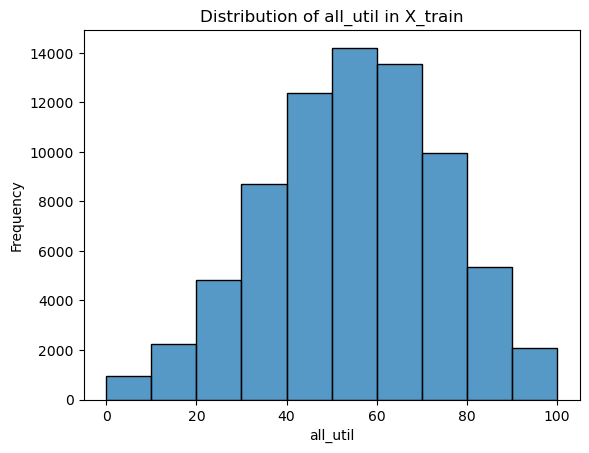

In [25]:
# Confirm that instances were removed.

# Visualize distribution of all_util
sns.histplot(X_train['all_util'], bins = 10)

# Add labels and title
plt.title('Distribution of all_util in X_train')
plt.xlabel('all_util')
plt.ylabel('Frequency')

plt.show()

### chargeoff_within_12_mths

In [ ]:
# Group by chargeoff_within_12_mths
X_train.groupby('chargeoff_within_12_mths').size()

chargeoff_within_12_mths
0    69913
1      357
2       19
3        3
4        1
6        2
dtype: int64

In [ ]:
# Most applicants do not have chargeoffs on record.
# Makes sense to convert ot a binary that measures if the applicant had a chargeoff if the last 12 months.
X_train['chargeoff_within_12_mths'] = np.where(X_train['chargeoff_within_12_mths'] > 0, 1, 0)
X_test['chargeoff_within_12_mths'] = np.where(X_test['chargeoff_within_12_mths'] > 0, 1, 0)

### collections_12_mths_ex_med

In [ ]:
# Group by collections_12_mths_ex_med
X_train.groupby('collections_12_mths_ex_med').size()

collections_12_mths_ex_med
0     69299
1       936
2        51
3         7
6         1
10        1
dtype: int64

In [ ]:
# Most applicants do not have collections on record.
# Makes sense to convert ot a binary that measures if the applicant had a collections if the last 12 months.
X_train['collections_12_mths_ex_med'] = np.where(X_train['collections_12_mths_ex_med'] > 0, 1, 0)
X_test['collections_12_mths_ex_med'] = np.where(X_test['collections_12_mths_ex_med'] > 0, 1, 0)

### delinq_2yrs

In [79]:
# Group by delinq_2yrs
X_train.groupby('delinq_2yrs').size()

delinq_2yrs
0     60514
1      6970
2      1645
3       607
4       260
5       127
6        66
7        44
8        24
9        17
10        9
11        5
12        2
13        2
15        1
17        2
dtype: int64

In [80]:
# Most applicants do not have delinquencies on record.
# Makes sense to convert ot a binary that measures if the applicant had a delinquencies if the last 2 years.
X_train['delinq_2yrs'] = np.where(X_train['delinq_2yrs'] > 0, 1, 0)
X_test['delinq_2yrs'] = np.where(X_test['delinq_2yrs'] > 0, 1, 0)

### annual_inc

Annual income is skewed right some extreme values. Even when removing instances > 99th percentile, it's still skewed right. A transformation will be applied to give annual income a normal distribution.

Any instances > 99th percentile will removed and square root transformation will be applied to the data that remains.

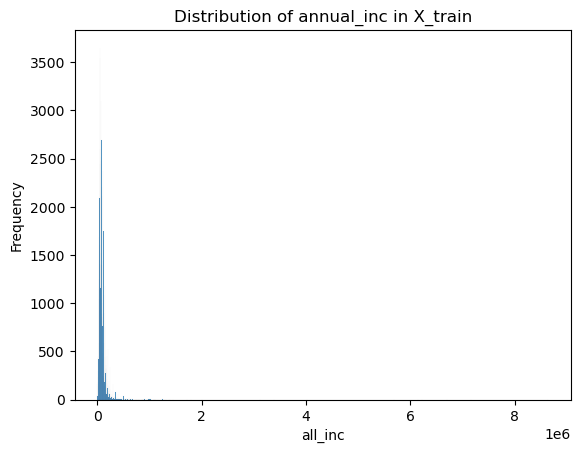

In [ ]:
# Visualize distribution of annual_inc
sns.histplot(X_train['annual_inc'])

# Add labels and title
plt.title('Distribution of annual_inc in X_train')
plt.xlabel('annual_inc')
plt.ylabel('Frequency')

plt.show()

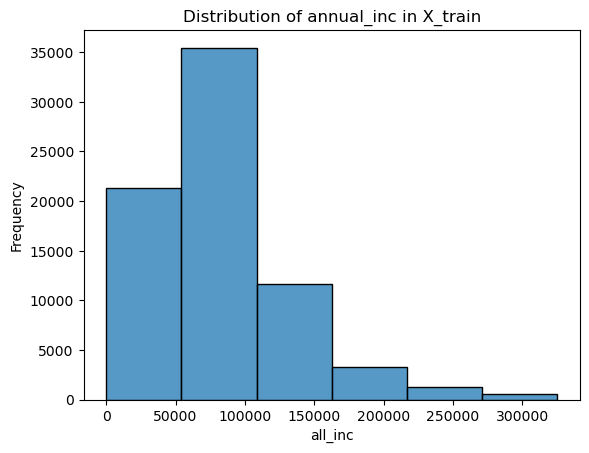

In [ ]:
# Long tail. Let's zoom in to just the 99th percentile

# Visualize distribution of annual_inc
sns.histplot(X_train.loc[X_train['annual_inc'] <= X_train['annual_inc'].quantile(0.99) ,'annual_inc'], binwidth = 50000)

# Add labels and title
plt.title('Distribution of annual_inc in X_train')
plt.xlabel('annual_inc')
plt.ylabel('Frequency')

plt.show()

In [28]:
# Looks better so let's remove the points > 99th percentile
X_train = X_train[X_train['annual_inc'] <= X_train['annual_inc'].quantile(0.99)]

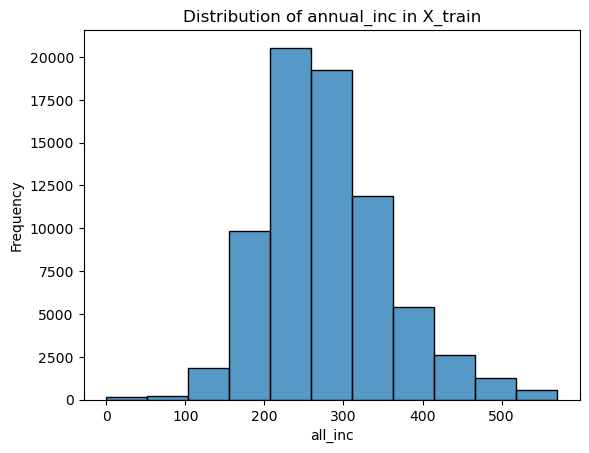

In [ ]:
# Since the data is still skewed right, let's explore a square root tranformation.

# Visualize distribution of annual_inc
sns.histplot(np.sqrt(X_train['annual_inc']), binwidth=50)

# Add labels and title
plt.title('Distribution of annual_inc in X_train')
plt.xlabel('annual_inc')
plt.ylabel('Frequency')

plt.show()

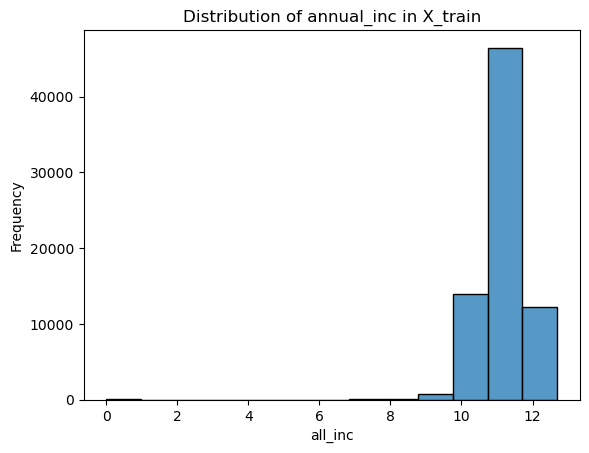

In [ ]:
# Let's explore a log transformation

# Visualize distribution of annual_inc
sns.histplot(np.log(X_train['annual_inc']+1), binwidth = 1)

# Add labels and title
plt.title('Distribution of annual_inc in X_train')
plt.xlabel('annual_inc')
plt.ylabel('Frequency')

plt.show()

In [42]:
# Apply a square root transformation to annual income
X_train['annual_inc_sqrt'] = np.sqrt(X_train['annual_inc'])
X_test['annual_inc_sqrt'] = np.sqrt(X_test['annual_inc'])

# Drop original columns
X_train = X_train.drop(columns = ['annual_inc'])
X_test = X_test.drop(columns = ['annual_inc'])

### dti

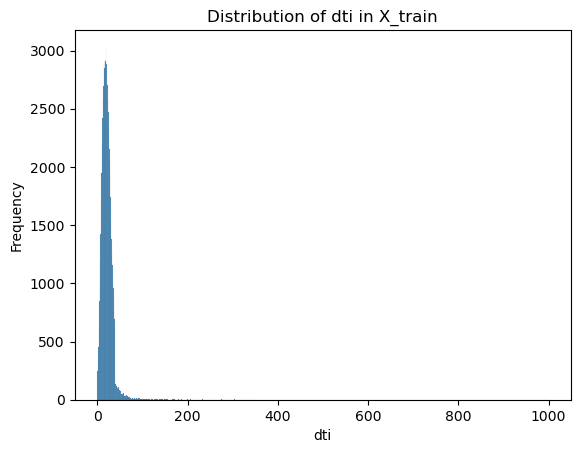

In [43]:
# Visualize distribution of all_util
sns.histplot(X_train['dti'], binwidth = 1)

# Add labels and title
plt.title('Distribution of dti in X_train')
plt.xlabel('dti')
plt.ylabel('Frequency')

plt.show()

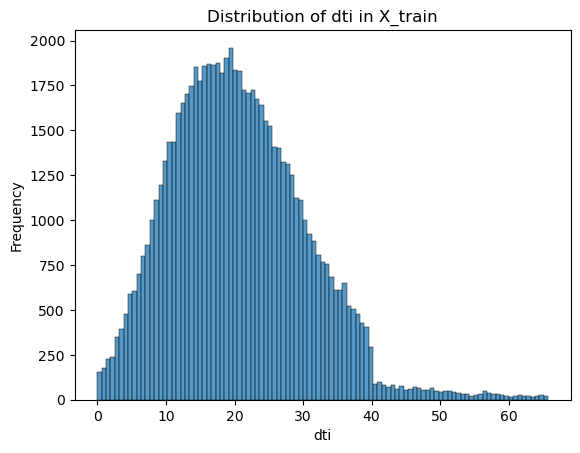

In [ ]:
# Long tail. Let's zoom in to just the 99th percentile. Data drops off at ~40.

# Visualize distribution of dti
sns.histplot(X_train.loc[X_train['dti'] <= X_train['dti'].quantile(0.99) ,'dti'])

# Add labels and title
plt.title('Distribution of dti in X_train')
plt.xlabel('dti')
plt.ylabel('Frequency')

plt.show()

In [49]:
# Instances > 40 will be removed
X_train = X_train[X_train['dti'] <= 40]

### Fico

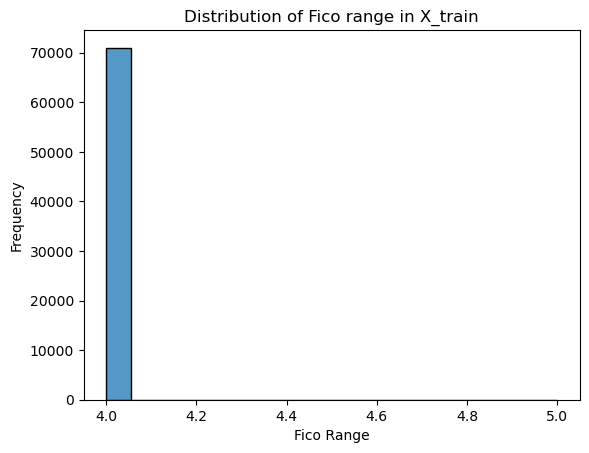

In [ ]:
# Data preview suggest there's a consistent difference between the high and low score. Let's verify.
sns.histplot(X_train['fico_range_high'] - X_train['fico_range_low'])

# Add labels and title
plt.title('Distribution of Fico range in X_train')
plt.xlabel('Fico Range')
plt.ylabel('Frequency')

plt.show()

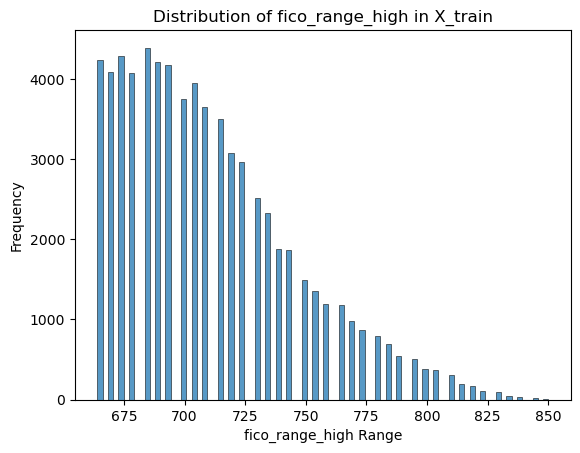

In [67]:
# Data preview suggest there's a consistent difference between the high and low score. Let's verify.
sns.histplot(X_train['fico_range_high'])

# Add labels and title
plt.title('Distribution of fico_range_high in X_train')
plt.xlabel('fico_range_high Range')
plt.ylabel('Frequency')

plt.show()

In [56]:
# It's all 4. Dropping the low column
X_train = X_train.drop(columns = ['fico_range_low'])
X_test = X_test.drop(columns = ['fico_range_low'])

### inq_last_12m

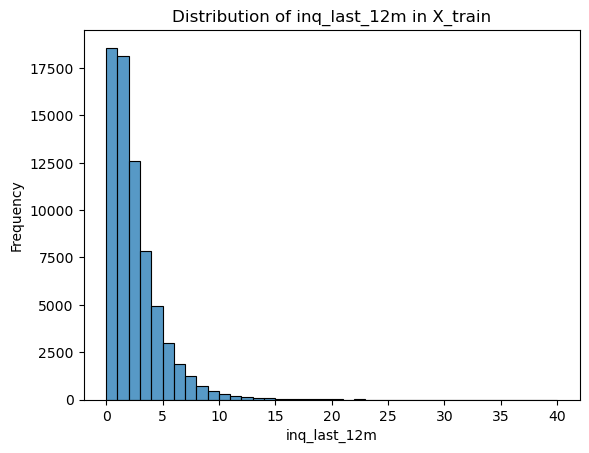

In [ ]:
# Visualize distribution of inq_last_12m
sns.histplot(X_train['inq_last_12m'], binwidth = 1)

# Add labels and title
plt.title('Distribution of inq_last_12m in X_train')
plt.xlabel('inq_last_12m')
plt.ylabel('Frequency')

plt.show()

In [ ]:
# 99% captured at 10.
X_train['inq_last_12m'].quantile(0.99)

10.0

In [84]:
# Remove instances where inquiries are greater than 10
X_train = X_train[X_train['inq_last_12m'] <= 10]

### mo_sin_old_il_acct

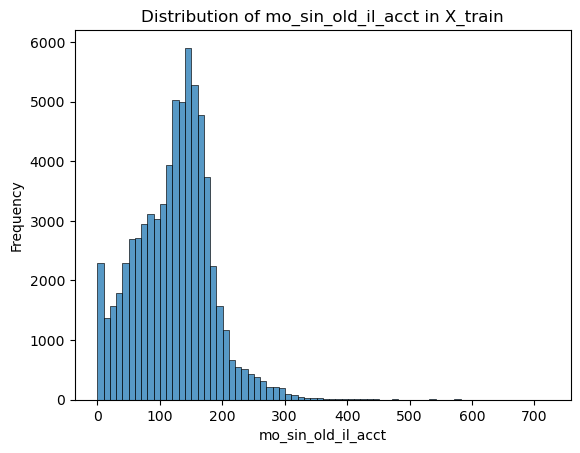

In [88]:
# Visualize distribution of mo_sin_old_il_acct
sns.histplot(X_train['mo_sin_old_il_acct'], binwidth = 10)

# Add labels and title
plt.title('Distribution of mo_sin_old_il_acct in X_train')
plt.xlabel('mo_sin_old_il_acct')
plt.ylabel('Frequency')

plt.show()

In [ ]:
# 99% captured at 287.
X_train['mo_sin_old_il_acct'].quantile(0.99)

287.0

In [101]:
# Remove instances where inquiries are greater than 287
X_train = X_train[X_train['mo_sin_old_il_acct'] <= 287]

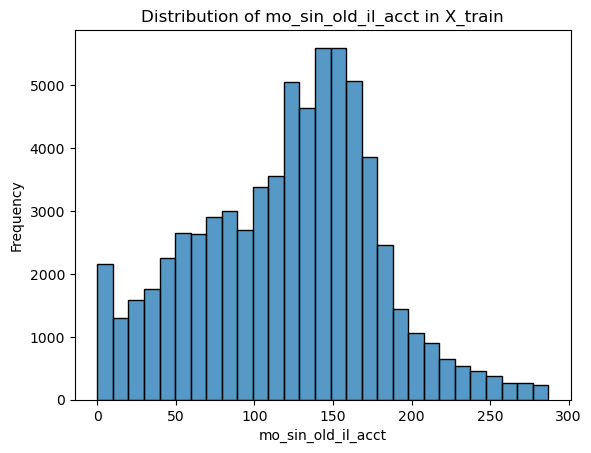

In [102]:
# Visualize distribution of mo_sin_old_il_acct
sns.histplot(X_train['mo_sin_old_il_acct'], binwidth = 10)

# Add labels and title
plt.title('Distribution of mo_sin_old_il_acct in X_train')
plt.xlabel('mo_sin_old_il_acct')
plt.ylabel('Frequency')

plt.show()

### mo_sin_old_rev_tl_op

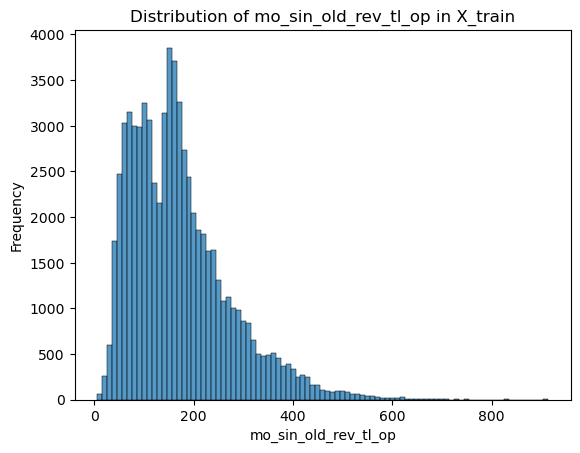

In [91]:
# Visualize distribution of mo_sin_old_rev_tl_op
sns.histplot(X_train['mo_sin_old_rev_tl_op'], binwidth = 10)

# Add labels and title
plt.title('Distribution of mo_sin_old_rev_tl_op in X_train')
plt.xlabel('mo_sin_old_rev_tl_op')
plt.ylabel('Frequency')

plt.show()

In [ ]:
# 99% captured at 287.
X_train['mo_sin_old_rev_tl_op'].quantile(0.99)

485.0

In [96]:
# Remove instances where inquiries are greater than 287
X_train = X_train[X_train['mo_sin_old_rev_tl_op'] <= 485]

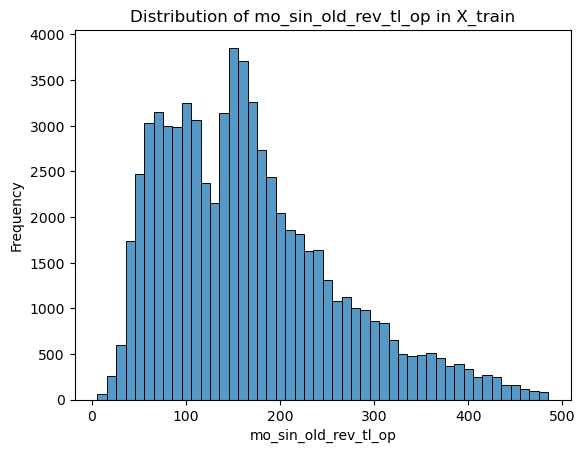

In [99]:
# Visualize distribution of mo_sin_old_rev_tl_op
sns.histplot(X_train['mo_sin_old_rev_tl_op'], binwidth = 10)

# Add labels and title
plt.title('Distribution of mo_sin_old_rev_tl_op in X_train')
plt.xlabel('mo_sin_old_rev_tl_op')
plt.ylabel('Frequency')

plt.show()

### mort_acc

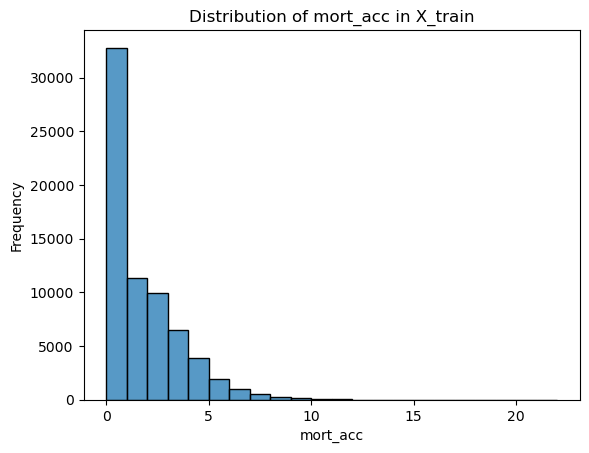

In [109]:
# Visualize distribution of mo_sin_old_rev_tl_op
sns.histplot(X_train['mort_acc'], binwidth = 1)

# Add labels and title
plt.title('Distribution of mort_acc in X_train')
plt.xlabel('mort_acc')
plt.ylabel('Frequency')

plt.show()

In [ ]:
# 99% captured at 7.
X_train['mort_acc'].quantile(0.99)

7.0

In [110]:
# Remove instances > 7
X_train = X_train[X_train['mort_acc'] <= 7]

# Add a binary column that evaluates if the applicant had mortgage account.
X_train['has_mort_acc'] = np.where(X_train['mort_acc'] > 0, 1, 0)

### mths_since_recent_inq

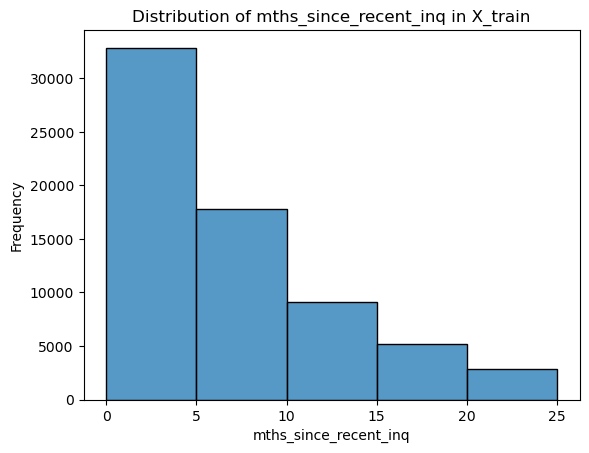

In [112]:
# Visualize distribution of mo_sin_old_rev_tl_op
sns.histplot(X_train['mths_since_recent_inq'], binwidth = 5)

# Add labels and title
plt.title('Distribution of mths_since_recent_inq in X_train')
plt.xlabel('mths_since_recent_inq')
plt.ylabel('Frequency')

plt.show()

### pub_rec_bankruptcies

In [116]:
# Group by chargeoff_within_12_mths
X_train.groupby('pub_rec_bankruptcies').size()

pub_rec_bankruptcies
0    61620
1     6128
2       72
3        6
4        3
7        1
dtype: int64

In [117]:
# Most applicants do not have bankruptcies on record.
# Makes sense to convert ot a binary that measures if the applicant had a bankruptcy.
X_train['pub_rec_bankruptcies'] = np.where(X_train['pub_rec_bankruptcies'] > 0, 1, 0)
X_test['pub_rec_bankruptcies'] = np.where(X_test['pub_rec_bankruptcies'] > 0, 1, 0)

### total_bal_ex_mort

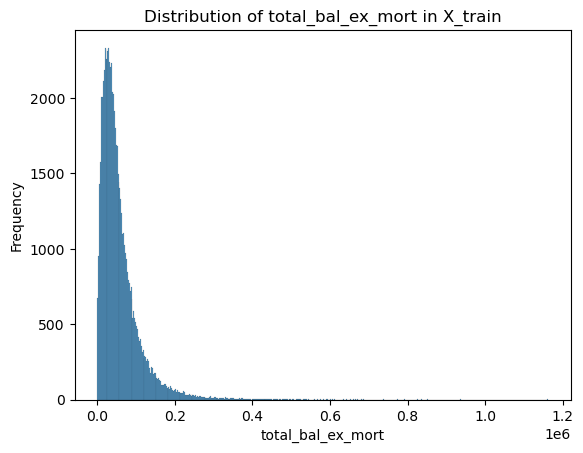

In [58]:
# Visualize distribution of total_bal_ex_mort
sns.histplot(X_train['total_bal_ex_mort'])

# Add labels and title
plt.title('Distribution of total_bal_ex_mort in X_train')
plt.xlabel('total_bal_ex_mort')
plt.ylabel('Frequency')

plt.show()

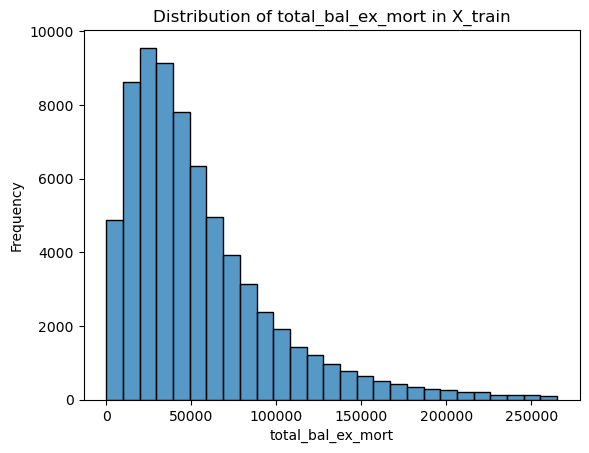

In [60]:
# Long tail. Let's zoom in to just the 99th percentile

# Visualize distribution of annual_inc
sns.histplot(X_train.loc[X_train['total_bal_ex_mort'] <= X_train['total_bal_ex_mort'].quantile(0.99) ,'total_bal_ex_mort'], binwidth = 10000)

# Add labels and title
plt.title('Distribution of total_bal_ex_mort in X_train')
plt.xlabel('total_bal_ex_mort')
plt.ylabel('Frequency')

plt.show()

In [61]:
# Looks better so let's remove the points > 99th percentile
X_train = X_train[X_train['total_bal_ex_mort'] <= X_train['total_bal_ex_mort'].quantile(0.99)]

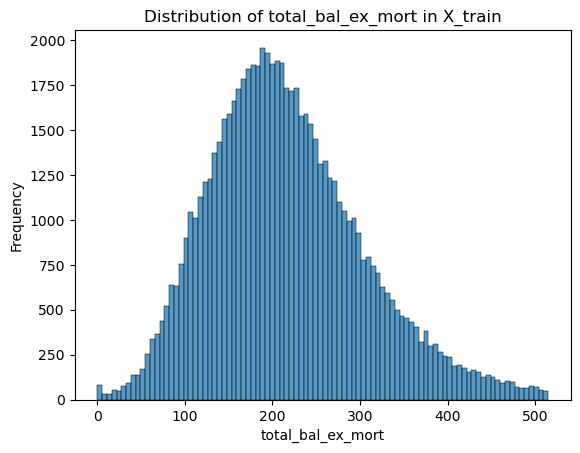

In [63]:
# Since the data is still skewed right, let's explore a square root tranformation.

# Visualize distribution of total_bal_ex_mort
sns.histplot(np.sqrt(X_train['total_bal_ex_mort']))

# Add labels and title
plt.title('Distribution of total_bal_ex_mort in X_train')
plt.xlabel('total_bal_ex_mort')
plt.ylabel('Frequency')

plt.show()

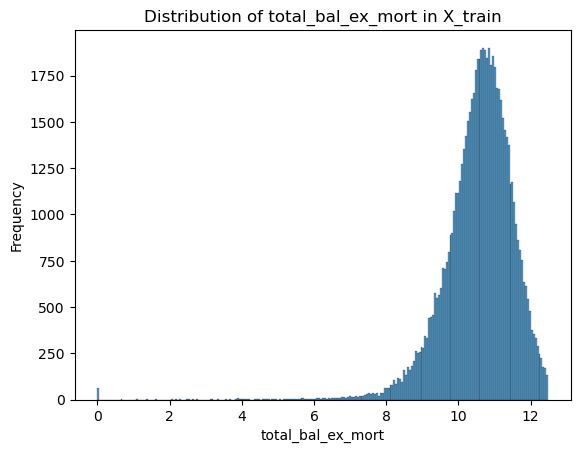

In [65]:
# Since the data is still skewed right, let's explore a log tranformation.

# Visualize distribution of total_bal_ex_mort
sns.histplot(np.log(X_train['total_bal_ex_mort']+1))

# Add labels and title
plt.title('Distribution of total_bal_ex_mort in X_train')
plt.xlabel('total_bal_ex_mort')
plt.ylabel('Frequency')

plt.show()

In [66]:
# Apply a square root transformation to annual income
X_train['total_bal_ex_mort_sqrt'] = np.sqrt(X_train['total_bal_ex_mort'])
X_test['total_bal_ex_mort_sqrt'] = np.sqrt(X_test['total_bal_ex_mort'])

# Drop original columns
X_train = X_train.drop(columns = ['total_bal_ex_mort'])
X_test = X_test.drop(columns = ['total_bal_ex_mort'])